### Setting Up Environment


In [1]:
import torch
import torchvision
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt

from pathlib import Path

from torch.utils.data import DataLoader


In [2]:
data_path = Path("DATASET/")

train_image_dir = data_path / "TRAIN"
test_image_dir = data_path / "TEST"

train_image_dir, test_image_dir


(WindowsPath('DATASET/TRAIN'), WindowsPath('DATASET/TEST'))

### Visualize Image

In [3]:
import os

for dirpath, dirname, filename in os.walk(data_path):
    print(dirpath, dirname, len(filename))



DATASET ['TEST', 'TRAIN'] 0
DATASET\TEST ['Organic', 'Recyclable'] 0
DATASET\TEST\Organic [] 1401
DATASET\TEST\Recyclable [] 1112
DATASET\TRAIN ['Organic', 'Recyclable'] 0
DATASET\TRAIN\Organic [] 12565
DATASET\TRAIN\Recyclable [] 9999


In [4]:
import random
from PIL import Image

# Set random seet
image_path_list = list(data_path.glob("*/*/*.jpg"))
image_path_list

sample_path_list = random.sample(image_path_list, k=10)
sample_path_list



[WindowsPath('DATASET/TRAIN/Recyclable/R_5491.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_8659.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_3972.jpg'),
 WindowsPath('DATASET/TRAIN/Recyclable/R_4825.jpg'),
 WindowsPath('DATASET/TRAIN/Recyclable/R_9424.jpg'),
 WindowsPath('DATASET/TEST/Organic/O_13503.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_11530.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_12061.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_628.jpg'),
 WindowsPath('DATASET/TRAIN/Organic/O_10356.jpg')]

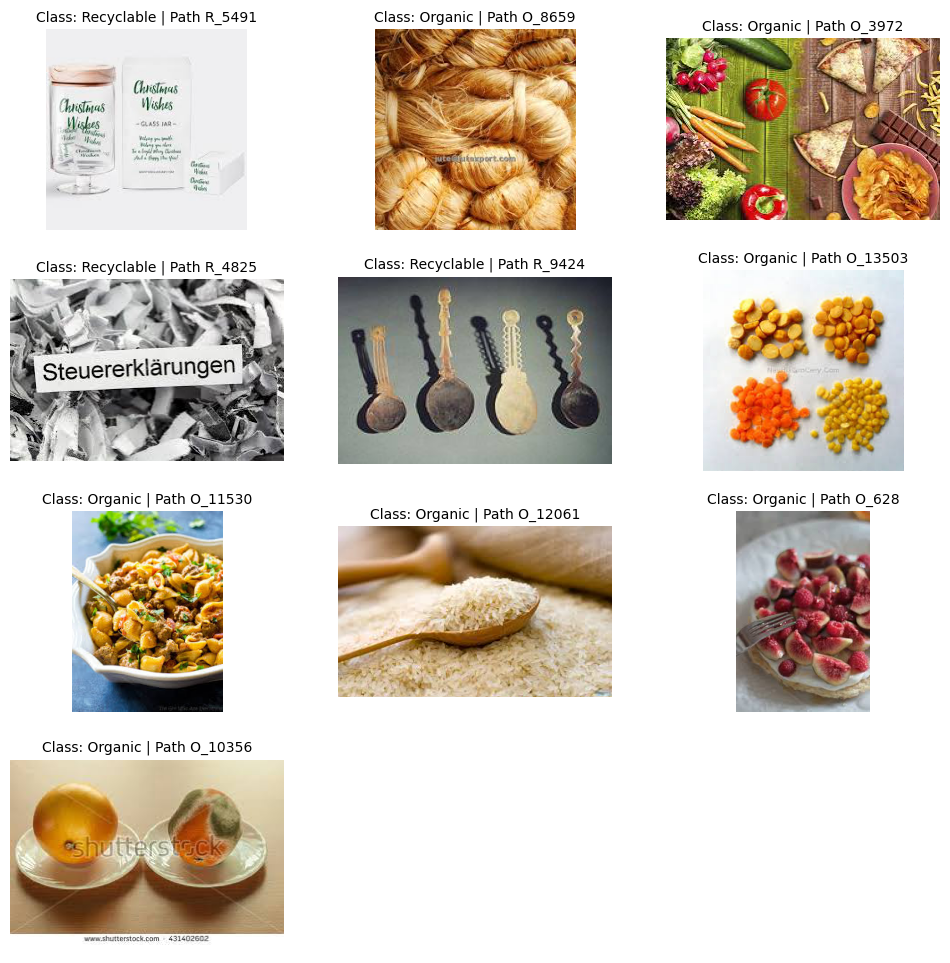

In [5]:
import matplotlib.image as mpimg

def display_image_in_grid(image_paths, grid_size=(4,3)):
    num_images = len(image_paths)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12,12))

    for i, ax in enumerate(axes.flat):
        ax.axis('off')
        if i < num_images:
            image_path = image_paths[i]
            image = mpimg.imread(image_path)
            ax.imshow(image)
            ax.set_title(f"Class: {image_paths[i].parent.stem} | Path {image_paths[i].stem}", fontsize=10)
        

display_image_in_grid(sample_path_list)

DATASET\TRAIN\Recyclable\R_5491.jpg
DATASET\TRAIN\Organic\O_8659.jpg
DATASET\TRAIN\Organic\O_3972.jpg
DATASET\TRAIN\Recyclable\R_4825.jpg
DATASET\TRAIN\Recyclable\R_9424.jpg
DATASET\TEST\Organic\O_13503.jpg
DATASET\TRAIN\Organic\O_11530.jpg
DATASET\TRAIN\Organic\O_12061.jpg
DATASET\TRAIN\Organic\O_628.jpg
DATASET\TRAIN\Organic\O_10356.jpg


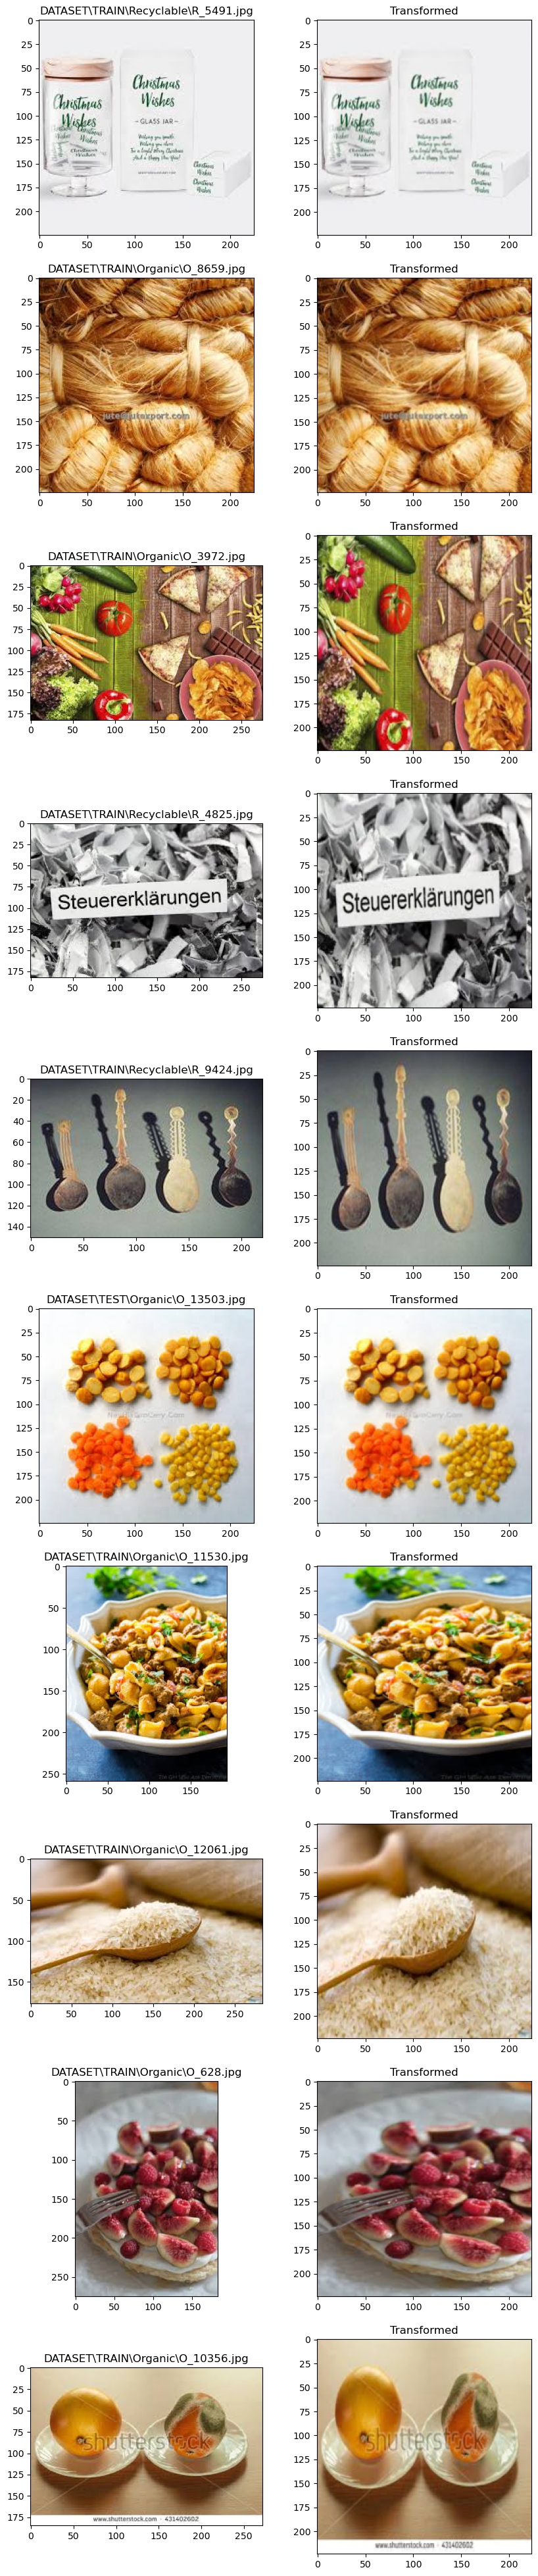

In [6]:
import matplotlib.image as mpimg
from PIL import Image
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

def display_image_before_after_transform(image_paths, transform, grid_size=(10,2)):
    num_images = len(image_paths)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 5*grid_size[0]))

    for i, ax_row in enumerate(axes):
        image_path = image_paths[i]
        print(image_path)
        for j, ax in enumerate(ax_row):
            # ax.set_title(f"Row: {i} | Col: {j} | Index: {i*2+j}")

            if j == 0:                
                image = mpimg.imread(image_path)
                ax.set_title(f"{image_path}")
                ax.imshow(image)
            else:
                image = Image.open(image_path)
                transformed_image = transform(image).permute(1,2,0) # Convert (C x H x W) to (H x W x C)
                ax.set_title(f"Transformed")
                ax.imshow(transformed_image)        
        

display_image_before_after_transform(sample_path_list, image_transform)

In [7]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_image_dir,
                                 transform=image_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_image_dir,
                                transform=image_transform)

train_data

Dataset ImageFolder
    Number of datapoints: 22564
    Root location: DATASET\TRAIN
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

!nvidia-smi

cuda
Thu Feb 29 11:09:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.70                 Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P8               3W /  80W |    271MiB /  6141MiB |     40%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

In [9]:
class_name = train_data.classes
class_name_idx = train_data.class_to_idx

print(class_name, class_name_idx)

['Organic', 'Recyclable'] {'Organic': 0, 'Recyclable': 1}


In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
NUM_WORKER = 1

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKER)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKER)

## Create Model

In [11]:
from torch import nn

class TinyVGGModel0(nn.Module):
    def __init__(self, input_shape: int, hidden_unit: int, output_shape:int) -> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1,
                         stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_unit * 56 * 56,
                      out_features=output_shape)
        )
    def forward(self, x:torch.Tensor):
        x = self.conv_block1(x)
        # print(x.shape)
        x = self.conv_block2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        
        return x

In [12]:
torch.manual_seed(42)
model_0 = TinyVGGModel0(input_shape=3,
                        hidden_unit=10,
                        output_shape=len(class_name)).to(device)
model_0

TinyVGGModel0(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=2, bias=True)
  )
)

In [13]:
image_batch, label_batch = next(iter(train_dataloader))

image_single, label_single = image_batch[0].unsqueeze(dim=0), label_batch[0]

In [14]:
image_single.shape

torch.Size([1, 3, 224, 224])

In [15]:
y_single = model_0(image_single.to(device))

torch.Size([1, 10, 112, 112])
torch.Size([1, 10, 56, 56])
torch.Size([1, 2])


## Train ModelTinyVGG

In [16]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    
    model.train()

    train_loss, train_acc = 0,0

    for batch, (X, y) in enumerate(dataloader):
        
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward Pass
        y_pred = model(X)

        # 2. Calculate Function Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer Zero Grad
        optimizer.zero_grad()

        # 4. Loss Backward
        loss.backward()

        # 5. Optimizer Step
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval()

    test_loss, test_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward Pass
        test_pred_logits = model(X)

        # 2. Calculate Loss
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc += (test_pred_labels == y).sum().item() / len(test_pred_logits)

    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc



In [17]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          device:torch.device,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          ):
    
    results = {"train_loss":[],
                 "train_acc": [],
                 "test_loss": [],
                 "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGGModel0(input_shape=3,
                        hidden_unit=10,
                        output_shape=len(class_name)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

In [21]:
from timeit import default_timer as timer

NUM_EPOCHS = 5

start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device=device,
                        epochs=NUM_EPOCHS)

end_time = timer()

print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Size([16, 10, 56, 56])
torch.Size([16, 2])
torch.Size([16, 10, 112, 112])
torch.Siz

KeyboardInterrupt: 